Selected features: ['cereal_yield', 'gni_per_cap', 'en_per_cap', 'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']
Best parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 70}
Mean CV R2 score: 0.986 ± 0.006
Test R2: 0.981, MSE: 0.352, RMSE: 0.593


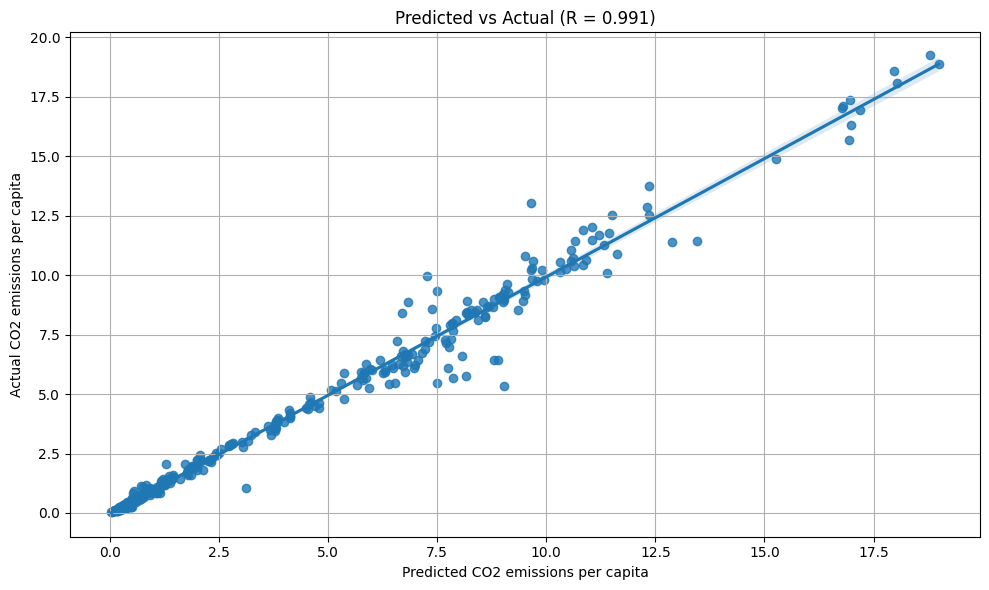

Model and selector saved successfully.

Calculated Growth Rates (CAGR):

IND:
  cereal_yield: +1.94%
  gni_per_cap: +6.85%
  en_per_cap: +2.12%
  pop_urb_aggl_perc: +1.26%
  prot_area_perc: +0.35%
  pop_growth_perc: -2.28%
  urb_pop_growth_perc: -1.26%

USA:
  cereal_yield: +2.28%
  gni_per_cap: +4.26%
  en_per_cap: -0.12%
  pop_urb_aggl_perc: +0.40%
  prot_area_perc: +0.01%
  pop_growth_perc: -2.16%
  urb_pop_growth_perc: -2.15%

PAK:
  cereal_yield: +2.29%
  gni_per_cap: +5.00%
  en_per_cap: +1.50%
  pop_urb_aggl_perc: +0.84%
  prot_area_perc: +0.01%
  pop_growth_perc: -2.46%
  urb_pop_growth_perc: -1.01%

RUS:
  cereal_yield: +1.99%
  gni_per_cap: +7.41%
  en_per_cap: -0.61%
  pop_urb_aggl_perc: +0.48%
  prot_area_perc: +0.46%

NZL:
  cereal_yield: +1.96%
  gni_per_cap: +5.00%
  en_per_cap: +0.39%
  pop_urb_aggl_perc: +1.15%
  prot_area_perc: +0.17%
  pop_growth_perc: -2.04%
  urb_pop_growth_perc: -1.83%


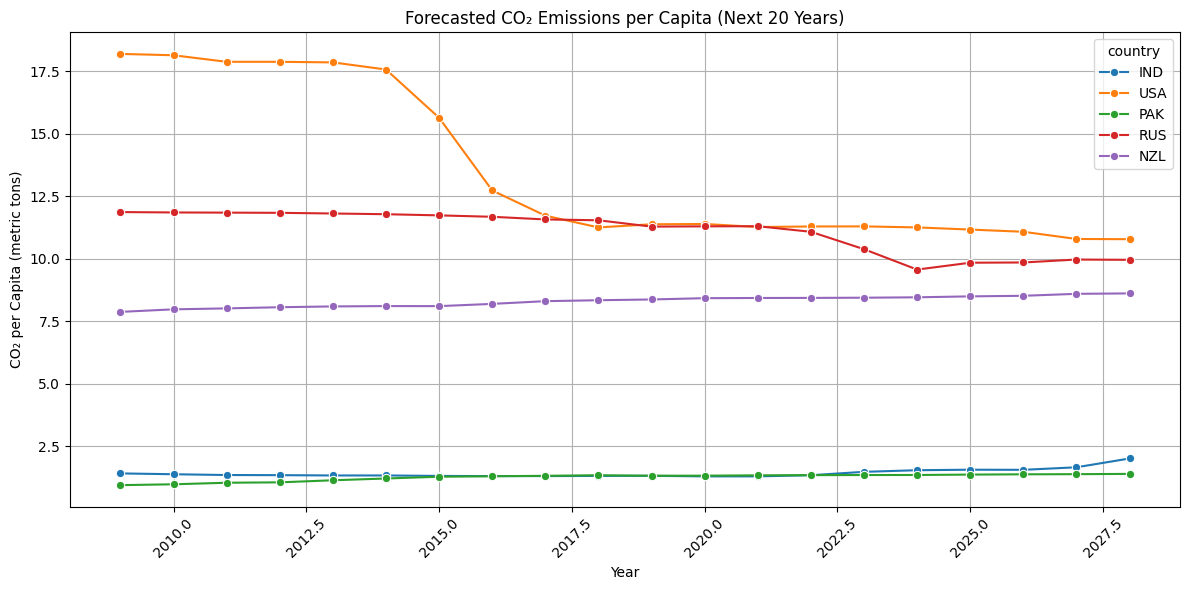


India CO₂ Forecast (Last 5 Years):
 year  co2_percap
 2024    1.541137
 2025    1.561721
 2026    1.556752
 2027    1.658534
 2028    2.010394


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# Configuration
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

# Load data
data = pd.read_csv('/content/Data_cleaned.csv')

# Remove outliers
data = data[data['country'] != 'ARE']

# Define features and label
feature_cols = ['cereal_yield', 'fdi_perc_gdp', 'gni_per_cap', 'en_per_cap',
                'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']
label_col = 'co2_per_cap'

# Drop rows with missing values
data = data.dropna(subset=feature_cols + [label_col])

# Prepare arrays
X = data[feature_cols].values
y = data[label_col].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Feature selection
rf_selector = RandomForestRegressor(random_state=RANDOM_STATE)
feature_folds = KFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

selector = RFECV(estimator=rf_selector, cv=feature_folds, scoring='r2', n_jobs=-1)
selector.fit(X_train, y_train)

selected_features = [feat for feat, selected in zip(feature_cols, selector.support_) if selected]
print(f"Selected features: {selected_features}")

# Transform data using selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 30, 50, 70, 90, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_tuner = RandomForestRegressor(random_state=RANDOM_STATE)
cv_folds = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf_model = RandomizedSearchCV(
    estimator=rf_tuner,
    param_distributions=param_grid,
    cv=cv_folds,
    scoring='r2',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_model.fit(X_train_selected, y_train)
best_model = rf_model.best_estimator_
print(f"Best parameters: {rf_model.best_params_}")

# Cross-validation evaluation
cv_scores = cross_val_score(
    best_model, X_train_selected, y_train,
    cv=KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE),
    scoring='r2'
)
print(f"Mean CV R2 score: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

# Test evaluation
y_pred = best_model.predict(X_test_selected)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test R2: {r2:.3f}, MSE: {mse:.3f}, RMSE: {rmse:.3f}")

# Visualization
plt.figure(figsize=(10, 6))
sns.regplot(x=y_pred, y=y_test, fit_reg=True)
plt.xlabel("Predicted CO2 emissions per capita")
plt.ylabel("Actual CO2 emissions per capita")
correlation = np.corrcoef(y_pred, y_test)[0, 1]
plt.title(f"Predicted vs Actual (R = {correlation:.3f})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Save model and selector
joblib.dump(best_model, 'co2_forecast_model.pkl')
joblib.dump(selector, 'feature_selector.pkl')
print("Model and selector saved successfully.")

# Forecasting setup
selected_countries = ['IND', 'USA', 'PAK', 'RUS', 'NZL']
growth_rates = {}

for country in selected_countries:
    country_data = data[data['country'] == country].sort_values('year')
    if len(country_data) < 2:
        continue
    start_year = country_data['year'].min()
    end_year = country_data['year'].max()
    years = end_year - start_year
    if years <= 0:
        continue

    country_growth = {}
    for feature in selected_features:
        start_vals = country_data[country_data['year'] == start_year][feature]
        end_vals = country_data[country_data['year'] == end_year][feature]
        if start_vals.empty or end_vals.empty:
            continue
        start_val = start_vals.iloc[0]
        end_val = end_vals.iloc[0]
        if start_val > 0 and end_val > 0 and np.isfinite(start_val) and np.isfinite(end_val):
            cagr = (end_val / start_val) ** (1 / years) - 1
            country_growth[feature] = cagr
    growth_rates[country] = country_growth

# Show growth rates
print("\nCalculated Growth Rates (CAGR):")
for country, features in growth_rates.items():
    print(f"\n{country}:")
    for feature, rate in features.items():
        print(f"  {feature}: {rate*100:+.2f}%")

# Forecast for 20 years
last_year = data['year'].max()
future_years = range(last_year + 1, last_year + 21)
forecast_results = []

for country in selected_countries:
    if country not in growth_rates:
        continue
    country_data = data[data['country'] == country].sort_values('year')
    latest_values = country_data[selected_features].dropna().iloc[-1].copy()
    for year in future_years:
        for feature in selected_features:
            growth_rate = growth_rates[country].get(feature, 0.0)
            latest_values[feature] *= (1 + growth_rate)
        input_features = latest_values.values.reshape(1, -1)
        predicted_co2 = best_model.predict(input_features)[0]
        forecast_results.append({
            'country': country,
            'year': year,
            'co2_percap': predicted_co2
        })

# Forecast DataFrame and plot
df_forecast = pd.DataFrame(forecast_results)
df_forecast = df_forecast.dropna(subset=['year', 'co2_percap'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='year', y='co2_percap', hue='country', marker='o')
plt.title('Forecasted CO₂ Emissions per Capita (Next 20 Years)')
plt.xlabel('Year')
plt.ylabel('CO₂ per Capita (metric tons)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Display last 5 years of forecast for India
india_forecast = df_forecast[df_forecast['country'] == 'IND'].tail(5)
print("\nIndia CO₂ Forecast (Last 5 Years):")
print(india_forecast[['year', 'co2_percap']].to_string(index=False))
